In [19]:
import os
import sys

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.datasets import load_svmlight_file
import torch
import difflib

#auto reload modules when changed
#%load_ext autoreload
#%autoreload 2


In [4]:
os.chdir(os.path.abspath(""))
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "src")))

from dataset.WideDataset import WideDataset
from preprocess.FeatureEvaluator import ImportanceEvaluator, CorrelationEvaluator
from dataset.SatelliteDataset import SatelliteDataset
from preprocess.FeatureEvaluator import CorrelationEvaluator

In [20]:
image_path = "data/real/nus-wide/uncompressed/images"
tag_path = "data/real/nus-wide/uncompressed/tags"
label_path = "data/real/nus-wide/uncompressed/labels"

train_test_wide_dataset = WideDataset.from_source(image_path, tag_path, label_path)
train_wide_dataset = train_test_wide_dataset.train
test_wide_dataset = train_test_wide_dataset.test
wide_Xs = []
for dataset in train_wide_dataset.local_datasets:
    print(dataset.X.shape)
    wide_Xs.append(dataset.X)

wide_Xs = wide_Xs[:5]   # remove the last party of tags

Loading CH...
Loading CORR...
Loading EDH...
Loading WT...
Loading CM55...
Loading tags...
Loading labels...
(161789, 65)
(161789, 145)
(161789, 74)
(161789, 129)
(161789, 226)
(161789, 1001)


CorrelationEvaluator uses cuda:0
Correlation calculation time: 10.05s
Inner score: 4.324589967727661, Inter score: 1.6242226511240005


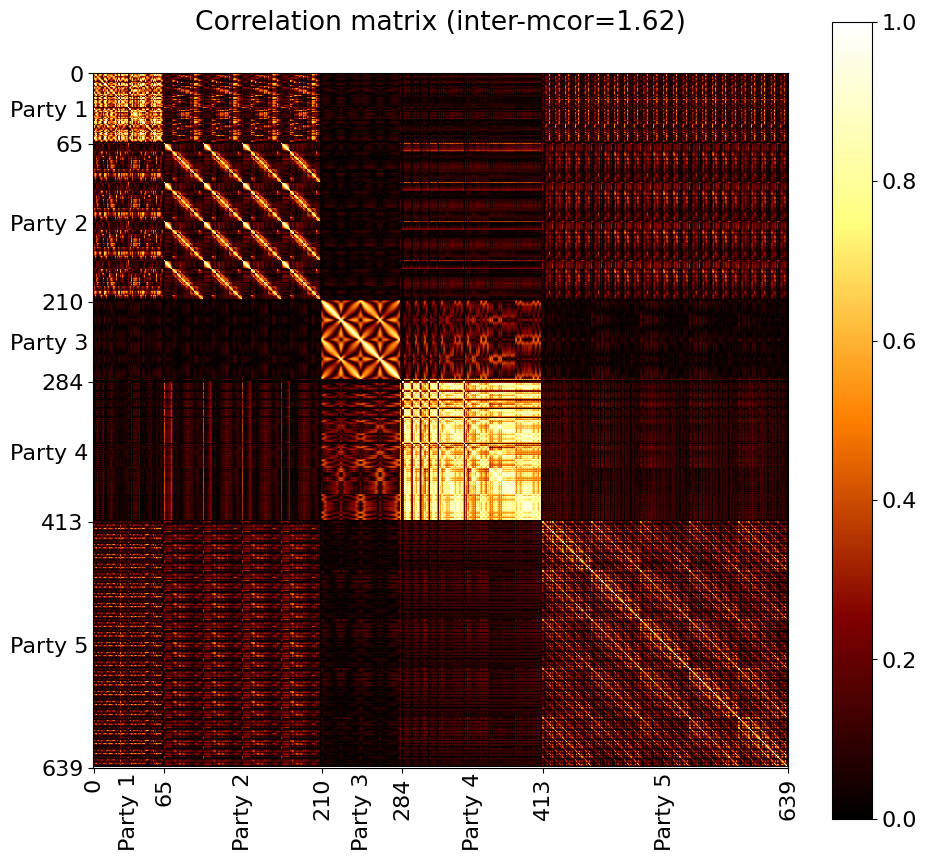

In [32]:
wide_corr_evaluator = CorrelationEvaluator(gpu_id=0)
score_wide = wide_corr_evaluator.fit_evaluate(wide_Xs)
wide_inner_score, wide_inter_score = wide_corr_evaluator._get_inner_and_inter_corr(wide_corr_evaluator.corr, wide_corr_evaluator.n_features_on_party)
print(f"Inner score: {np.mean(wide_inner_score)}, Inter score: {np.mean(wide_inter_score)}")

wide_corr_evaluator.visualize(value=score_wide, cmap="afmhot")

CorrelationEvaluator uses cuda:0
Cut points: [ 65 210 284 413 639]
Size of Xs: [(161789, 65), (161789, 145), (161789, 74), (161789, 129), (161789, 226)]
Correlation calculation time: 9.86s
Inner score: 2.435580921173096, Inter score: 2.5946702480316164


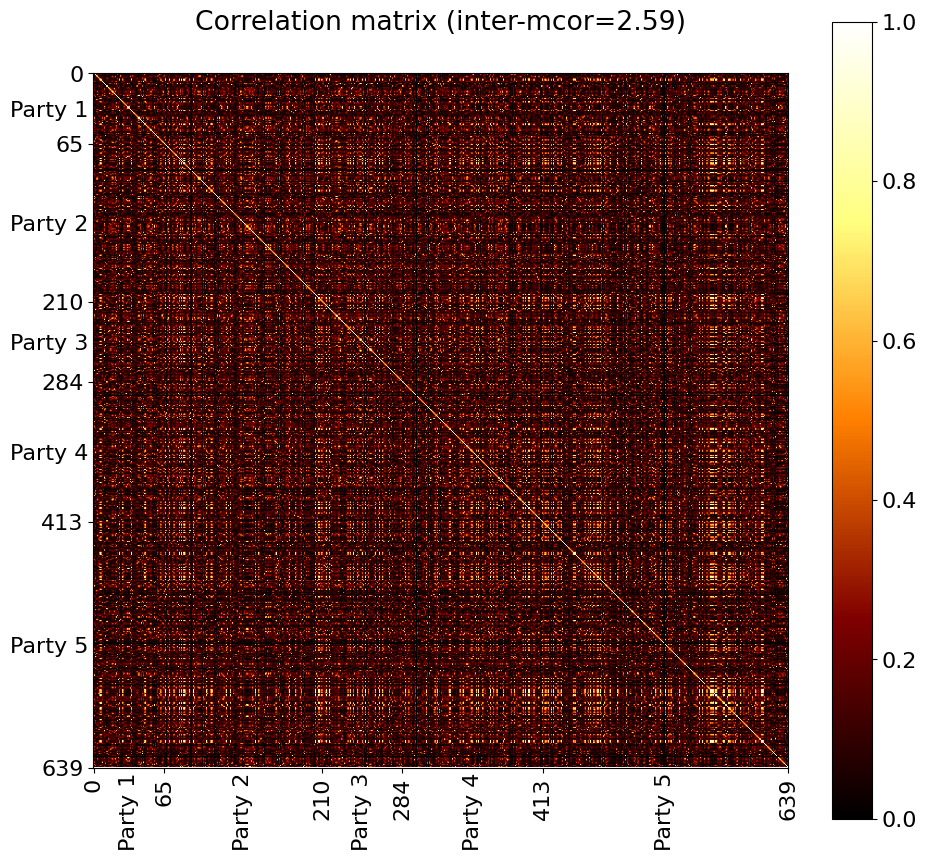

In [37]:
wide_shuffle_corr_evaluator = CorrelationEvaluator(gpu_id=0)
feature_cut_points = np.cumsum([X.shape[1] for X in wide_Xs])
print(f"Cut points: {feature_cut_points}")
wide_shuffle_X = np.concatenate(wide_Xs, axis=1)
wide_shuffle_X = wide_shuffle_X[:, np.random.permutation(wide_shuffle_X.shape[1])]
wide_shuffle_Xs = np.split(wide_shuffle_X, feature_cut_points, axis=1)[:-1]
print(f"Size of Xs: {[X.shape for X in wide_shuffle_Xs]}")
score_wide_shuffle = wide_shuffle_corr_evaluator.fit_evaluate(wide_shuffle_Xs)
wide_shuffle_inner_score, wide_shuffle_inter_score = wide_shuffle_corr_evaluator._get_inner_and_inter_corr(wide_shuffle_corr_evaluator.corr, wide_shuffle_corr_evaluator.n_features_on_party)
print(f"Inner score: {np.mean(wide_shuffle_inner_score)}, Inter score: {np.mean(wide_shuffle_inter_score)}")
wide_shuffle_corr_evaluator.visualize(value=score_wide_shuffle, cmap="afmhot")

CorrelationEvaluator uses cuda:0
Correlation calculation time: 0.79s
Inner score: 2.5867664217948914, Inter score: 0.314446821808815


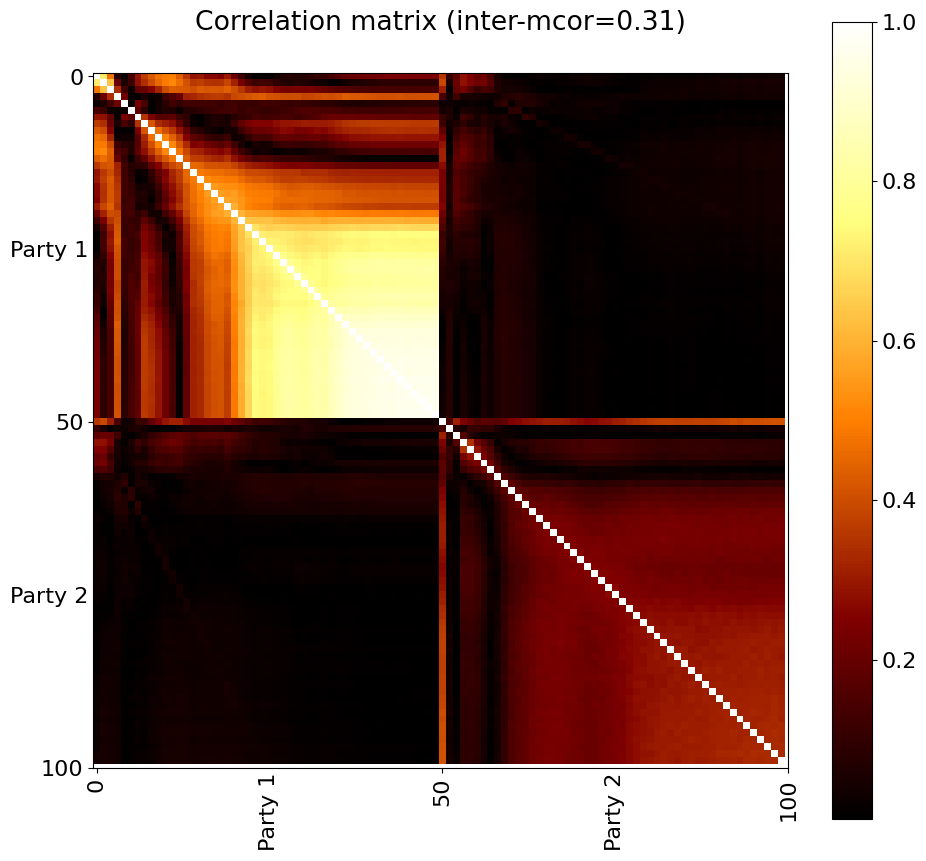

In [38]:
# vehicle dataset
vehicle_X, _ = load_svmlight_file("data/real/vehicle/processed/vehicle.libsvm")
vehicle_X = vehicle_X.toarray()

vehicle_Xs = [vehicle_X[:, :50], vehicle_X[:, 50:]]
vehicle_evaluator = CorrelationEvaluator(gpu_id=0)
vehicle_score = vehicle_evaluator.fit_evaluate(vehicle_Xs)
vehicle_inner_score, vehicle_inter_score = vehicle_evaluator._get_inner_and_inter_corr(vehicle_evaluator.corr, vehicle_evaluator.n_features_on_party)
print(f"Inner score: {np.mean(vehicle_inner_score)}, Inter score: {np.mean(vehicle_inter_score)}")
vehicle_evaluator.visualize(value=vehicle_score, cmap="afmhot")


CorrelationEvaluator uses cuda:0
Correlation calculation time: 0.77s
Inner score: 1.9773465991020203, Inter score: 1.9551552534103394


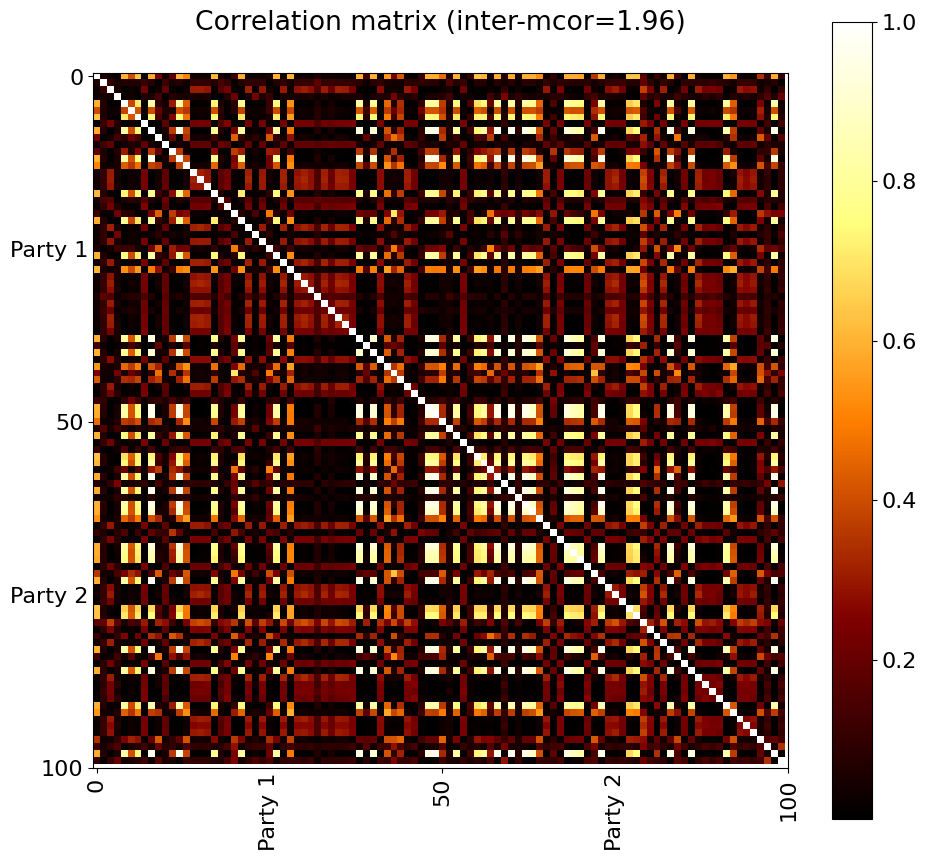

In [39]:
vehicle_shuffle_X = np.concatenate(vehicle_Xs, axis=1)
vehicle_shuffle_X = vehicle_shuffle_X[:, np.random.permutation(vehicle_shuffle_X.shape[1])]
vehicle_shuffle_Xs = np.split(vehicle_shuffle_X, [50, 100], axis=1)[:-1]
vehicle_shuffle_evaluator = CorrelationEvaluator(gpu_id=0)
vehicle_shuffle_score = vehicle_shuffle_evaluator.fit_evaluate(vehicle_shuffle_Xs)
vehicle_shuffle_inner_score, vehicle_shuffle_inter_score = vehicle_shuffle_evaluator._get_inner_and_inter_corr(vehicle_shuffle_evaluator.corr, vehicle_shuffle_evaluator.n_features_on_party)
print(f"Inner score: {np.mean(vehicle_shuffle_inner_score)}, Inter score: {np.mean(vehicle_shuffle_inter_score)}")
vehicle_shuffle_evaluator.visualize(value=vehicle_shuffle_score, cmap="afmhot")

In [41]:
# satellite dataset
satellite_data = SatelliteDataset.from_pickle("data/real/satellite/cache/", n_jobs=8)
satellite_Xs = []
for dataset in satellite_data.local_datasets:
    satellite_Xs.append(dataset.X)
print(f"Size of Xs: {[X.shape for X in satellite_Xs]}")

100%|█████████████████████████████████████████████████████████████████████████████████| 16/16 [00:58<00:00,  3.65s/it]

Size of Xs: [torch.Size([3142, 13, 158, 158]), torch.Size([3142, 13, 158, 158]), torch.Size([3142, 13, 158, 158]), torch.Size([3142, 13, 158, 158]), torch.Size([3142, 13, 158, 158]), torch.Size([3142, 13, 158, 158]), torch.Size([3142, 13, 158, 158]), torch.Size([3142, 13, 158, 158]), torch.Size([3142, 13, 158, 158]), torch.Size([3142, 13, 158, 158]), torch.Size([3142, 13, 158, 158]), torch.Size([3142, 13, 158, 158]), torch.Size([3142, 13, 158, 158]), torch.Size([3142, 13, 158, 158]), torch.Size([3142, 13, 158, 158]), torch.Size([3142, 13, 158, 158])]


In [46]:
satellite_Xs_sample_flatten = []
satellite_n_features = 500
for X in satellite_Xs:
    X_flatten = X.reshape(X.shape[0], -1)
    X_sample = X_flatten[:, np.random.permutation(X_flatten.shape[1])[:satellite_n_features]]
    satellite_Xs_sample_flatten.append(X_sample)
print(f"Size of Xs: {[X.shape for X in satellite_Xs_sample_flatten]}")

Size of Xs: [torch.Size([3142, 500]), torch.Size([3142, 500]), torch.Size([3142, 500]), torch.Size([3142, 500]), torch.Size([3142, 500]), torch.Size([3142, 500]), torch.Size([3142, 500]), torch.Size([3142, 500]), torch.Size([3142, 500]), torch.Size([3142, 500]), torch.Size([3142, 500]), torch.Size([3142, 500]), torch.Size([3142, 500]), torch.Size([3142, 500]), torch.Size([3142, 500]), torch.Size([3142, 500])]


CorrelationEvaluator uses cuda:0
Correlation calculation time: 15.85s
Inner score: 11.89376425743103, Inter score: 6.7538336455821995


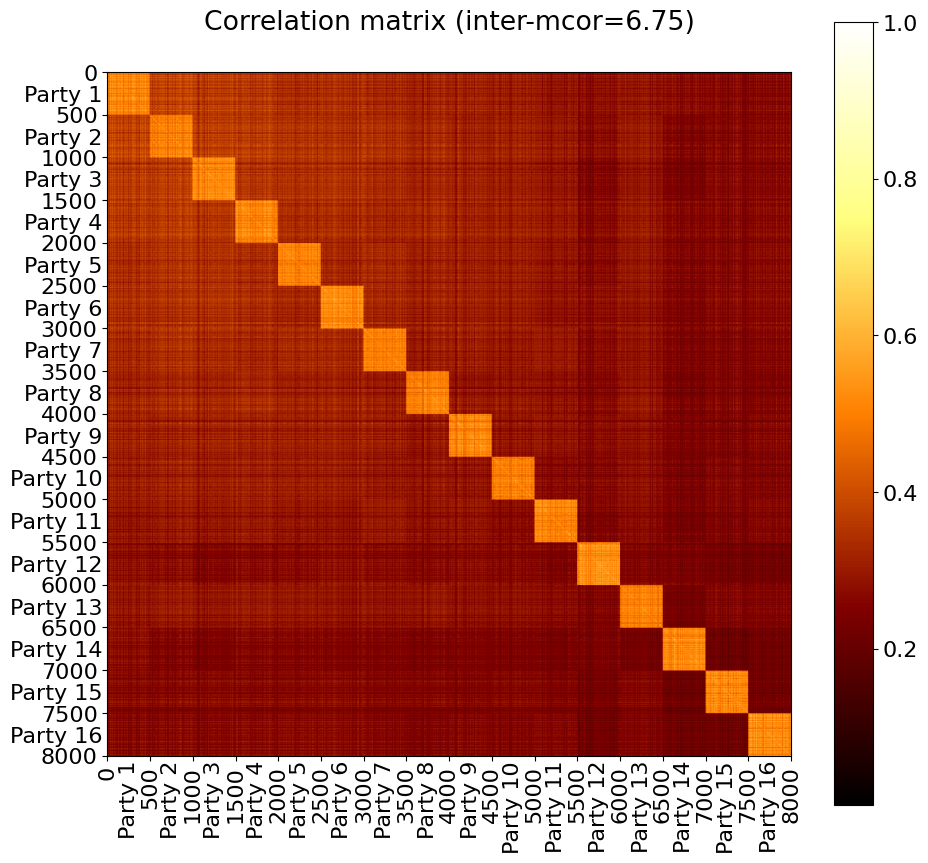

In [47]:
satellite_evaluator = CorrelationEvaluator(gpu_id=0)
satellite_score = satellite_evaluator.fit_evaluate(satellite_Xs_sample_flatten)
satellite_inner_score, satellite_inter_score = satellite_evaluator._get_inner_and_inter_corr(satellite_evaluator.corr, satellite_evaluator.n_features_on_party)
print(f"Inner score: {np.mean(satellite_inner_score)}, Inter score: {np.mean(satellite_inter_score)}")
satellite_evaluator.visualize(value=satellite_score, cmap="afmhot")


CorrelationEvaluator uses cuda:0
Correlation calculation time: 15.60s
Inner score: 7.237331062555313, Inter score: 7.1923970301946


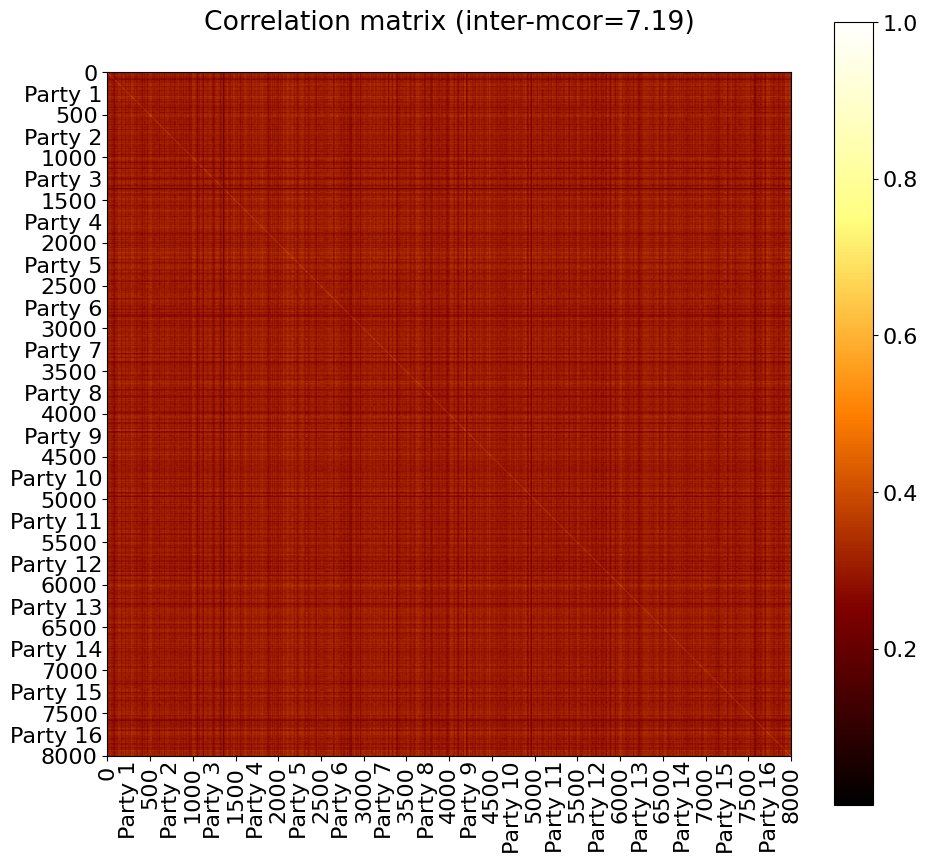

In [50]:
satellite_shuffle_X = np.concatenate(satellite_Xs_sample_flatten, axis=1)
satellite_shuffle_X = satellite_shuffle_X[:, np.random.permutation(satellite_shuffle_X.shape[1])]
Xs_cut_points = np.cumsum([X.shape[1] for X in satellite_Xs_sample_flatten])
satellite_shuffle_Xs = np.split(satellite_shuffle_X, Xs_cut_points, axis=1)[:-1]
satellite_shuffle_evaluator = CorrelationEvaluator(gpu_id=0)
satellite_shuffle_score = satellite_shuffle_evaluator.fit_evaluate(satellite_shuffle_Xs)
satellite_shuffle_inner_score, satellite_shuffle_inter_score = satellite_shuffle_evaluator._get_inner_and_inter_corr(satellite_shuffle_evaluator.corr, satellite_shuffle_evaluator.n_features_on_party)
print(f"Inner score: {np.mean(satellite_shuffle_inner_score)}, Inter score: {np.mean(satellite_shuffle_inter_score)}")
satellite_shuffle_evaluator.visualize(value=satellite_shuffle_score, cmap="afmhot")

In [32]:
# paper dataset
iclr2021_df = pd.read_csv("data/real/paper/raw/iclr2021-list.tsv", sep="\t", index_col=0)
neurips2021_df = pd.read_csv("data/real/paper/raw/neurips2021-list.tsv", sep="\t", index_col=0)
iclr2022_df = pd.read_csv("data/real/paper/raw/iclr2022-list.tsv", sep="\t", index_col=0)
neurips2022_df = pd.read_csv("data/real/paper/raw/neurips2022-list.tsv", sep="\t", index_col=0)
iclr2023_df = pd.read_csv("data/real/paper/raw/iclr2023-list.tsv", sep="\t", index_col=0)
print(f"Size of ICLR2021: {iclr2021_df.shape}, Size of NeurIPS2021: {neurips2021_df.shape}")
print(f"Size of ICLR2022: {iclr2022_df.shape}, Size of NeurIPS2022: {neurips2022_df.shape}")
print(f"Size of ICLR2023: {iclr2023_df.shape}")
# remove all rows with NaN in any column
iclr2021_df_clean = iclr2021_df.dropna(axis=0, how="any")
neurips2021_df_clean = neurips2021_df.dropna(axis=0, how="any")
iclr2022_df_clean = iclr2022_df.dropna(axis=0, how="any")
neurips2022_df_clean = neurips2022_df.dropna(axis=0, how="any")
iclr2023_df_clean = iclr2023_df.dropna(axis=0, how="any")
print(f"Cleaned - Size of ICLR2021: {iclr2021_df_clean.shape}, Size of NeurIPS2021: {neurips2021_df_clean.shape}")
print(f"Cleaned - Size of ICLR2022: {iclr2022_df_clean.shape}, Size of NeurIPS2022: {neurips2022_df_clean.shape}")
print(f"Cleaned - Size of ICLR2023: {iclr2023_df_clean.shape}")

Size of ICLR2021: (3094, 6), Size of NeurIPS2021: (2769, 6)
Size of ICLR2022: (3447, 6), Size of NeurIPS2022: (2824, 6)
Size of ICLR2023: (4960, 6)
Cleaned - Size of ICLR2021: (2950, 6), Size of NeurIPS2021: (2745, 6)
Cleaned - Size of ICLR2022: (3380, 6), Size of NeurIPS2022: (2823, 6)
Cleaned - Size of ICLR2023: (4906, 6)


In [37]:
def replace_with_closest_match(s1, column):
    match = difflib.get_close_matches(s1, column, n=1, cutoff=0.7)
    if len(match) > 0:
        return match[0]
    else:
        return s1

iclr2021_df_clean["title_sim"] = iclr2021_df_clean["title"].apply(lambda x: replace_with_closest_match(x, neurips2022_df_clean["title"]))
neurips2022_df_clean["title_sim"] = neurips2022_df_clean["title"]
print("Replaced ICLR2021 titles with closest match in NeurIPS2021. Start merging...")
common_2021_df = pd.merge(iclr2021_df_clean, neurips2022_df_clean, how="inner", on="title_sim")
print(f"Size of common: {common_2021_df.shape}")


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Replaced ICLR2021 titles with closest match in NeurIPS2021. Start merging...
Size of common: (119, 13)


In [36]:
common_2021_df

,title_x,authors_x,pdf_url_x,forum_url_x,n_replies_x,category_x,title_sim,title_y,authors_y,pdf_url_y,forum_url_y,n_replies_y,category_y
0,Optimism in Reinforcement Learning with Genera...,"Yining Wang,Ruosong Wang,Simon Shaolei Du,Aksh...",https://openreview.net/pdf?id=CBmJwzneppz,https://openreview.net/forum?id=CBmJwzneppz,13,poster-presentations,Open-Ended Reinforcement Learning with Neural ...,Open-Ended Reinforcement Learning with Neural ...,"Robert Meier,Asier Mujika",https://openreview.net/pdf?id=NL05_JGVg99,https://openreview.net/forum?id=NL05_JGVg99,20,accepted-papers
1,On the Transfer of Disentangled Representation...,"Andrea Dittadi,Frederik Träuble,Francesco Loca...",https://openreview.net/pdf?id=8VXvj1QNRl1,https://openreview.net/forum?id=8VXvj1QNRl1,9,poster-presentations,Temporally Disentangled Representation Learning,Temporally Disentangled Representation Learning,"Weiran Yao,Guangyi Chen,Kun Zhang",https://openreview.net/pdf?id=Vi-sZWNA_Ue,https://openreview.net/forum?id=Vi-sZWNA_Ue,30,accepted-papers
2,Improving Zero-Shot Voice Style Transfer via D...,"Siyang Yuan,Pengyu Cheng,Ruiyi Zhang,Weituo Ha...",https://openreview.net/pdf?id=TgSVWXw22FQ,https://openreview.net/forum?id=TgSVWXw22FQ,9,poster-presentations,Temporally Disentangled Representation Learning,Temporally Disentangled Representation Learning,"Weiran Yao,Guangyi Chen,Kun Zhang",https://openreview.net/pdf?id=Vi-sZWNA_Ue,https://openreview.net/forum?id=Vi-sZWNA_Ue,30,accepted-papers
3,Multi-View Disentangled Representation,"Zongbo Han,Changqing Zhang,Huazhu Fu,Qinghua H...",https://openreview.net/pdf?id=RSn0s-T-qoy,https://openreview.net/forum?id=RSn0s-T-qoy,9,withdrawn-rejected-submissions,Temporally Disentangled Representation Learning,Temporally Disentangled Representation Learning,"Weiran Yao,Guangyi Chen,Kun Zhang",https://openreview.net/pdf?id=Vi-sZWNA_Ue,https://openreview.net/forum?id=Vi-sZWNA_Ue,30,accepted-papers
4,On Disentangled Representations Extracted from...,"Valentin Khrulkov,Leyla Mirvakhabova,Ivan Osel...",https://openreview.net/pdf?id=VCAXR34cp59,https://openreview.net/forum?id=VCAXR34cp59,8,withdrawn-rejected-submissions,Temporally Disentangled Representation Learning,Temporally Disentangled Representation Learning,"Weiran Yao,Guangyi Chen,Kun Zhang",https://openreview.net/pdf?id=Vi-sZWNA_Ue,https://openreview.net/forum?id=Vi-sZWNA_Ue,30,accepted-papers
...,...,...,...,...,...,...,...,...,...,...,...,...,...
679,Mirror Sample Based Distribution Alignment for...,"Yin Zhao,Minquan Wang,Longjun Cai",https://openreview.net/pdf?id=XS_E9MiQeVk,https://openreview.net/forum?id=XS_E9MiQeVk,5,withdrawn-rejected-submissions,Subsidiary Prototype Alignment for Universal D...,Subsidiary Prototype Alignment for Universal D...,"Jogendra Nath Kundu,Suvaansh Bhambri,Akshay Ra...",https://openreview.net/pdf?id=5kThooa07pf,https://openreview.net/forum?id=5kThooa07pf,15,accepted-papers
680,Fast Estimation for Privacy and Utility in Dif...,"Yuzhe Li,Yong Liu,Weipinng Wang,Bo Li,Nan Liu",https://openreview.net/pdf?id=Xu6K3lGBPAS,https://openreview.net/forum?id=Xu6K3lGBPAS,35,withdrawn-rejected-submissions,A General Framework for Auditing Differentiall...,A General Framework for Auditing Differentiall...,"Fred Lu,Joseph Munoz,Maya Fuchs,Tyler LeBlond,...",https://openreview.net/pdf?id=AKM3C3tsSx3,https://openreview.net/forum?id=AKM3C3tsSx3,12,accepted-papers
681,IF-Defense: 3D Adversarial Point Cloud Defense...,"Ziyi Wu,Yueqi Duan,He Wang,Qingnan Fan,Leonida...",https://openreview.net/pdf?id=2bw8QFtPAZD,https://openreview.net/forum?id=2bw8QFtPAZD,5,withdrawn-rejected-submissions,DISCO: Adversarial Defense with Local Implicit...,DISCO: Adversarial Defense with Local Implicit...,"Chih-Hui Ho,Nuno Vasconcelos",https://openreview.net/pdf?id=vgIz0emVTAd,https://openreview.net/forum?id=vgIz0emVTAd,15,accepted-papers
682,Training-Free Uncertainty Estimation for Dense...,"Lu Mi,Hao Wang,Yonglong Tian,Nir Shavit",https://openreview.net/pdf?id=3cCWBFRuZBI,https:/

In [35]:
iclr2022_df_clean["title_sim"] = iclr2022_df_clean["title"].apply(lambda x: replace_with_closest_match(x, iclr2021_df_clean["title"]))
iclr2021_df_clean["title_sim"] = iclr2021_df_clean["title"]
print("Replaced ICLR2022 titles with closest match in ICLR2021. Start merging...")
common_iclr_df = pd.merge(iclr2022_df_clean, iclr2021_df_clean, how="inner", on="title_sim")
print(f"Size of common: {common_iclr_df.shape}")

Replaced ICLR2022 titles with closest match in ICLR2021. Start merging...
Size of common: (921, 13)



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Cleaned - Size of ICLR2023: (4906, 6)
Replaced NeurIPS2022 titles with closest match in ICLR2023. Start merging...



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [38]:
print("Hi")

Hi
